In [2]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.spatial.distance as distance

In [9]:
# enc radius
# dmax is dimension of complex
# will compue H_0, H_1, ..., until H_{dmax-1}
# default flag: clearing with basis
def BATS_rips_enc(F_X, dmax = 2, degree = +1,
flags = (bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())):
#     t0 = time.monotonic()
#     DX = distance.squareform(distance.pdist(X))
#     rX = bats.enclosing_radius(bats.Matrix(DX))
#     F_X = bats.LightRipsFiltration(bats.Matrix(DX), rX, dmax)
    FVS = bats.FilteredF2DGVectorSpace(F_X, degree)
    RFVS = bats.ReducedFilteredF2DGVectorSpace(FVS, *flags)
#     t1 = time.monotonic()
    return RFVS

In [ ]:



# Update with max radius (see the effect of permutations)
# Note: update must include flag bats.compute_basis_flag()
# dmax is max dimension of complex
def time_BATS_update_full_rips(X, Y, rX = np.inf, rY = np.inf, dmax = 2, degree = +1,
flags = (bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())):
    # computation on X
    F_X = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), rX, dmax)
    FVS = bats.FilteredF2DGVectorSpace(F_X, degree)
    RFVS = bats.ReducedFilteredF2DGVectorSpace(FVS, *flags) 

    # return time spent on updating Y
    t0 = time.monotonic()
    F_Y = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), rY, dmax)
    UI = bats.UpdateInfo2(F_X, F_Y)
    RFVS.update(UI)
    t1 = time.monotonic()
    # print("Update: {} sec.".format(t1 - t0))
    return t1-t0

# Update with enc radius (see the effect of permutations/addition/deletion)
def time_BATS_update_enc_rips(X, Y, dmax = 2, degree = +1,
flags = (bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())):
    # computation on X
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F_X = bats.LightRipsFiltration(bats.Matrix(DX), rX, dmax)
    FVS = bats.FilteredF2DGVectorSpace(F_X, degree)
    RFVS = bats.ReducedFilteredF2DGVectorSpace(FVS, *flags) 

    # return time spent on updating Y
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = bats.enclosing_radius(bats.Matrix(DY))
    F_Y = bats.LightRipsFiltration(bats.Matrix(DY), rY, dmax)
    UI = bats.UpdateInfo2(F_X, F_Y)
    RFVS.update(UI)
    t1 = time.monotonic()
    # print("Update: {} sec.".format(t1 - t0))
    return t1-t0


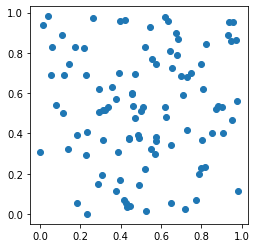

In [12]:
n = 100
X = np.random.uniform(0,1,(n,2))
# X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
# X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig1 = plt.scatter(X[:,0], X[:,1])
fig1.axes.set_aspect('equal')
# plt.savefig('orginal_dataset_rips.png')
# plt.clf()

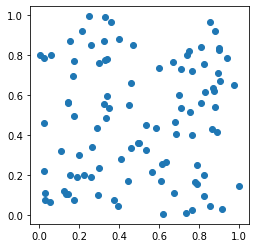

In [23]:
n = 100
X = np.random.uniform(0,1,(n,2))
fig1 = plt.scatter(X[:,0], X[:,1])
fig1.axes.set_aspect('equal')
# plt.savefig('orginal_dataset_rips.png')
# plt.clf()

nnz_ = []
tlist = []
lr = 1e-2 # persistence penalty


t0 = time.monotonic()
DX = distance.squareform(distance.pdist(X))
rX = bats.enclosing_radius(bats.Matrix(DX))
F, imap = bats.LightRipsFiltration_extension(bats.Matrix(DX), rX , 2)
# R = bats.reduce(F, bats.F2())
R = BATS_rips_enc(F, degree = -1)
t1 = time.monotonic()
#print("initialization: {} sec.".format(t1-t0))
F_old = F

iter_times = 200
for i in range(iter_times):
#     print("iter", i)
    # Optimize H1 length
    # get 1-dimensional pairs
    
    ps = R.persistence_pairs(1)
    t1a = time.monotonic()
    #print("\tfind pairs: {} sec.".format(t1a - t0))
    
    t0b = time.monotonic()
    complex_old = F_old.complex() # complex of filtration
    filtration_vals_old = F_old.vals(1) # filtration vals at dimension 1
    
    # change the posistion of two vertices 
    # that are related to the birth of the persistence pair

    #print("rX = ", rX)
    for p in ps:
        if p.length() > 0:
        # if p.length() > 0 and np.abs(p.birth() - rX) > 1e-4:
            #print(p)
            d = p.dim()
            # get indices of two vertices of the (birth) edge 
            bi = p.birth_ind() # index of birth edge 
            [birth_vertex1_i, birth_vertex2_i] = complex_old.get_simplex(1, bi)
            # Gradient Descent
            grad_div_2 = 2 * (p.death() - p.birth())* (X[birth_vertex1_i] - X[birth_vertex2_i])
            X[birth_vertex1_i] -=  (lr/ filtration_vals_old[bi]) * (grad_div_2)
            X[birth_vertex2_i] +=  (lr/ filtration_vals_old[bi]) * (grad_div_2)
            #print("update birth success")
            # get the death index of related edge
            if p.death_ind() > len(imap[d+1])-1:
                print("death index exceed limit: ", p.death_ind()) 
                print("p is ", p)
            
            if p.death() != float('inf') and p.death_ind() <= len(imap[d+1])-1:
                di = imap[d+1][p.death_ind()] # maps death_ind to the death edge (related to the 2-simplex destroys H1)
                # get index of two vertices of the (birth) edge 
                [death_vertex1_i, death_vertex2_i] = complex_old.get_simplex(1, di)
                # Gradient Descent
                grad_div_2 = 2 * (p.death() - p.birth()) *  (X[death_vertex1_i] - X[death_vertex2_i])
                X[death_vertex1_i] +=  (lr/ filtration_vals_old[di]) * (grad_div_2)
                X[death_vertex2_i] -=  (lr/ filtration_vals_old[di]) * (grad_div_2)
                #print("update death success")
            
        
    # Update Persistence
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F_new, imap = bats.LightRipsFiltration_extension(bats.Matrix(DX), rX, 2)
#     UI = bats.UpdateInfoLightFiltration(F_old, F_new)
#     R.update_filtration_general(UI)
    UI = bats.UpdateInfo2(F_old, F_new)
    R.update(UI)
    t1 = time.monotonic()
    tlist.append(t1 - t0)
    
    # Set old Filtration    
    F_old = F_new


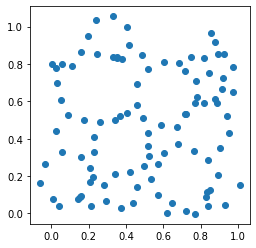

In [24]:
fig2 = plt.scatter(X[:,0], X[:,1])
fig2.axes.set_aspect('equal')

In [17]:

tlist = np.array(tlist)

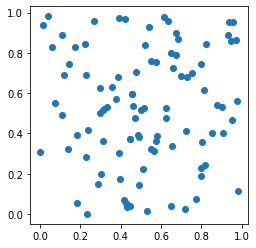

In [16]:
fig2 = plt.scatter(X[:,0], X[:,1])
fig2.axes.set_aspect('equal')
# plt.savefig('optimized_dataset_rips.png')
# plt.clf()

# fig3 = plt.figure(figsize=(8, 6))
# plt.subplot(2, 1, 1)
# plt.title('Sum of non-zeros in U and R v.s. number of iterations n')
# plt.plot(np.arange(iter_times), nnz_, c = 'g')
# plt.xlabel('number of iterations n')
# plt.ylabel('number of non-zeros')


# plt.subplot(2, 1, 2)
# plt.title('Updating Time v.s. Sum of non-zeros of U and R')
# plt.scatter(nnz_, tlist, c = 'r')
# plt.xlabel('number of non-zeros')
# plt.ylabel('Time')

# fig3.tight_layout()
# plt.savefig('opt_rips_results.png')
# plt.clf()